In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as ss
from scipy.stats import skew

pd.set_option("display.max_rows" , 100)

%matplotlib inline

In [2]:
traindf = pd.read_csv("./Datasets/adv-house-pred/train.csv")
testdf = pd.read_csv("./Datasets/adv-house-pred/test.csv")

In [3]:
traindf.drop("Id" , axis = 1 , inplace=True)
testdf.drop("Id" , axis = 1 , inplace=True)

In [4]:
quantitative = [f for f in traindf.columns if traindf.dtypes[f] != 'object']
quantitative.remove('SalePrice')
qualitative = [f for f in traindf.columns if traindf.dtypes[f] == 'object']

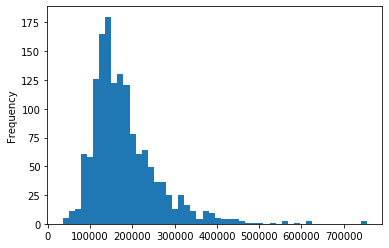

In [5]:
traindf["SalePrice"].plot(kind="hist" , bins=50)

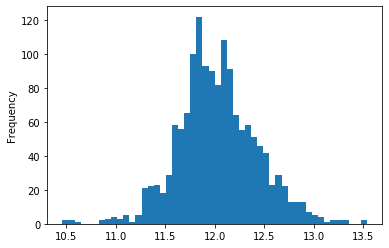

In [6]:
traindf["SalePrice"] = traindf["SalePrice"].apply(np.log)
traindf["SalePrice"].plot(kind="hist" , bins=50)

In [7]:
# Testing wether other input features come from normal distribution or not
normal = traindf[quantitative].apply(lambda x : ss.shapiro(x)[1] < 0.05)
normal

MSSubClass        True
LotFrontage      False
LotArea           True
OverallQual       True
OverallCond       True
YearBuilt         True
YearRemodAdd      True
MasVnrArea       False
BsmtFinSF1        True
BsmtFinSF2        True
BsmtUnfSF         True
TotalBsmtSF       True
1stFlrSF          True
2ndFlrSF          True
LowQualFinSF      True
GrLivArea         True
BsmtFullBath      True
BsmtHalfBath      True
FullBath          True
HalfBath          True
BedroomAbvGr      True
KitchenAbvGr      True
TotRmsAbvGrd      True
Fireplaces        True
GarageYrBlt      False
GarageCars        True
GarageArea        True
WoodDeckSF        True
OpenPorchSF       True
EnclosedPorch     True
3SsnPorch         True
ScreenPorch       True
PoolArea          True
MiscVal           True
MoSold            True
YrSold            True
dtype: bool

In [8]:
# Outlinears
traindf = traindf.drop(traindf[(traindf['GrLivArea']>4000) & (traindf['SalePrice']<12.5)].index)
traindf.reset_index(drop = True, inplace = True)

In [9]:
# EDA
plt.figure(figsize=[12,14])

n=1
for f in quantitative:
    plt.subplot(10,4,n)
    sns.distplot(traindf[f], kde=False)
    sns.despine()
    n=n+1
plt.tight_layout()
plt.show()

In [10]:
fig = plt.figure(figsize=(25,25))
ax1 = fig.add_subplot(1,1,1)

sns.heatmap(traindf[quantitative].corr("spearman") , vmin=-1.0 , vmax=1.0 , cmap="YlGnBu" , square=True , annot=True)

In [11]:
traindf.drop(["GarageArea","TotRmsAbvGrd"],axis=1 , inplace = True)
testdf.drop(["GarageArea","TotRmsAbvGrd"],axis=1 , inplace = True)

In [12]:
# traindf.isnull().sum()*100/traindf.shape[0]

In [13]:
null_cols = traindf.isnull().sum()/traindf.shape[0] > 0.8

for col in traindf.columns:
    if null_cols[col]:
        traindf.drop(col , axis = 1 , inplace = True)
        testdf.drop(col , axis = 1 , inplace = True)
traindf.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorc

In [14]:
traindf.drop(1379 , axis = 0 , inplace=True) # Only row missing electrical in train as well as test set

In [15]:
for col in traindf.select_dtypes("object"):
    traindf[col] = traindf[col].fillna('None')
    testdf[col] = testdf[col].fillna('None')

In [16]:
for col in traindf.drop("SalePrice" , axis = 1).select_dtypes(["int64" , "float64"]):
    traindf[col] = traindf[col].fillna(traindf[col].mean())
    testdf[col] = testdf[col].fillna(traindf[col].mean())

In [17]:
df = pd.concat([traindf , testdf] , axis = 0 , ignore_index=True)
df.reset_index(drop=True , inplace=True)

numeric_feats = df.dtypes[df.dtypes != "object"].index

skewed_feats = df[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_feats

In [18]:
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

high_skew = skewed_feats[skewed_feats > 0.5]
skew_index = high_skew.index

# Normalise skewed features
for i in skew_index:
    traindf[i] = boxcox1p(df[i], boxcox_normmax(df[i] + 1))

traindf = df.copy().iloc[:traindf.shape[0]]
testdf = df.copy().iloc[traindf.shape[0]:]

In [19]:
# Mean encoding qualitative variables
def find_mean_encoding(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
    
    return ordering

def encode(frame , feature , ordering):
    for cat, o in ordering.items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o
    
qual_encoded = []
for q in traindf.select_dtypes("object"):  
    order = find_mean_encoding(traindf , q)
    encode(traindf, q , order)
    encode(testdf , q , order)
    qual_encoded.append(q+'_E')
    testdf[q + "_E"].fillna(traindf[q + "_E"].mean() , inplace=True)

# testdf.fillna(0 , inplace = True) # To account for class which appeard in test but not in train

In [20]:
traindf.drop(list(traindf.select_dtypes("object").columns) , axis = 1 , inplace=True)
testdf.drop(list(testdf.select_dtypes("object").columns) , axis = 1 , inplace=True)

In [21]:
traindf.isnull().sum().sum()

0

In [22]:
testdf.isnull().sum().sum()

0

In [23]:
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split , cross_val_score
from xgboost import XGBRegressor

In [24]:
target = traindf["SalePrice"]
traindf.drop("SalePrice" , axis = 1 , inplace = True)
scaler = RobustScaler()
dataset = pd.concat([traindf , testdf] , axis = 0 , ignore_index=True)
dataset.reset_index(drop=True , inplace=True)
dataset = pd.DataFrame(scaler.fit_transform(dataset),columns=dataset.columns)
traindf = dataset.iloc[:traindf.shape[0]]
testdf = dataset.iloc[traindf.shape[0]:]

In [25]:
skew(traindf) > 0.75

array([ True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True, False,  True,  True, False, False, False, False,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False])

In [26]:
clf = RandomForestRegressor(n_jobs=-1)

In [27]:
clf.fit(traindf.values , target.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [28]:
clf.feature_importances_

array([1.78852982e-03, 4.32471985e-03, 1.15106425e-02, 5.48634015e-01,
       1.06490000e-02, 7.28659059e-03, 7.06727215e-03, 2.51480947e-03,
       2.03839930e-02, 4.33623694e-04, 5.09968304e-03, 3.77025233e-02,
       2.41582010e-02, 4.25760730e-03, 1.74424202e-04, 1.12972772e-01,
       1.98689130e-03, 2.89461598e-04, 1.16591459e-03, 8.69602836e-04,
       1.64140148e-03, 1.30514266e-03, 1.85233109e-03, 4.18824610e-03,
       3.35394832e-02, 2.71937878e-03, 4.67168530e-03, 1.96255895e-03,
       2.28584878e-04, 6.03696787e-04, 3.03740351e-05, 2.85313269e-04,
       3.68252100e-03, 1.63620938e-03, 5.17454910e-03, 8.67498603e-05,
       5.59041723e-04, 9.15462948e-04, 9.66055578e-06, 7.53438851e-04,
       8.40172941e-04, 7.34094735e-02, 7.81752844e-04, 3.39858911e-05,
       4.85435846e-04, 9.29265475e-04, 8.61275284e-04, 2.59848425e-04,
       2.30458938e-03, 2.18056777e-03, 6.76750811e-04, 1.38522440e-03,
       2.85945157e-03, 8.48456675e-04, 4.13424497e-03, 1.93586780e-03,
      

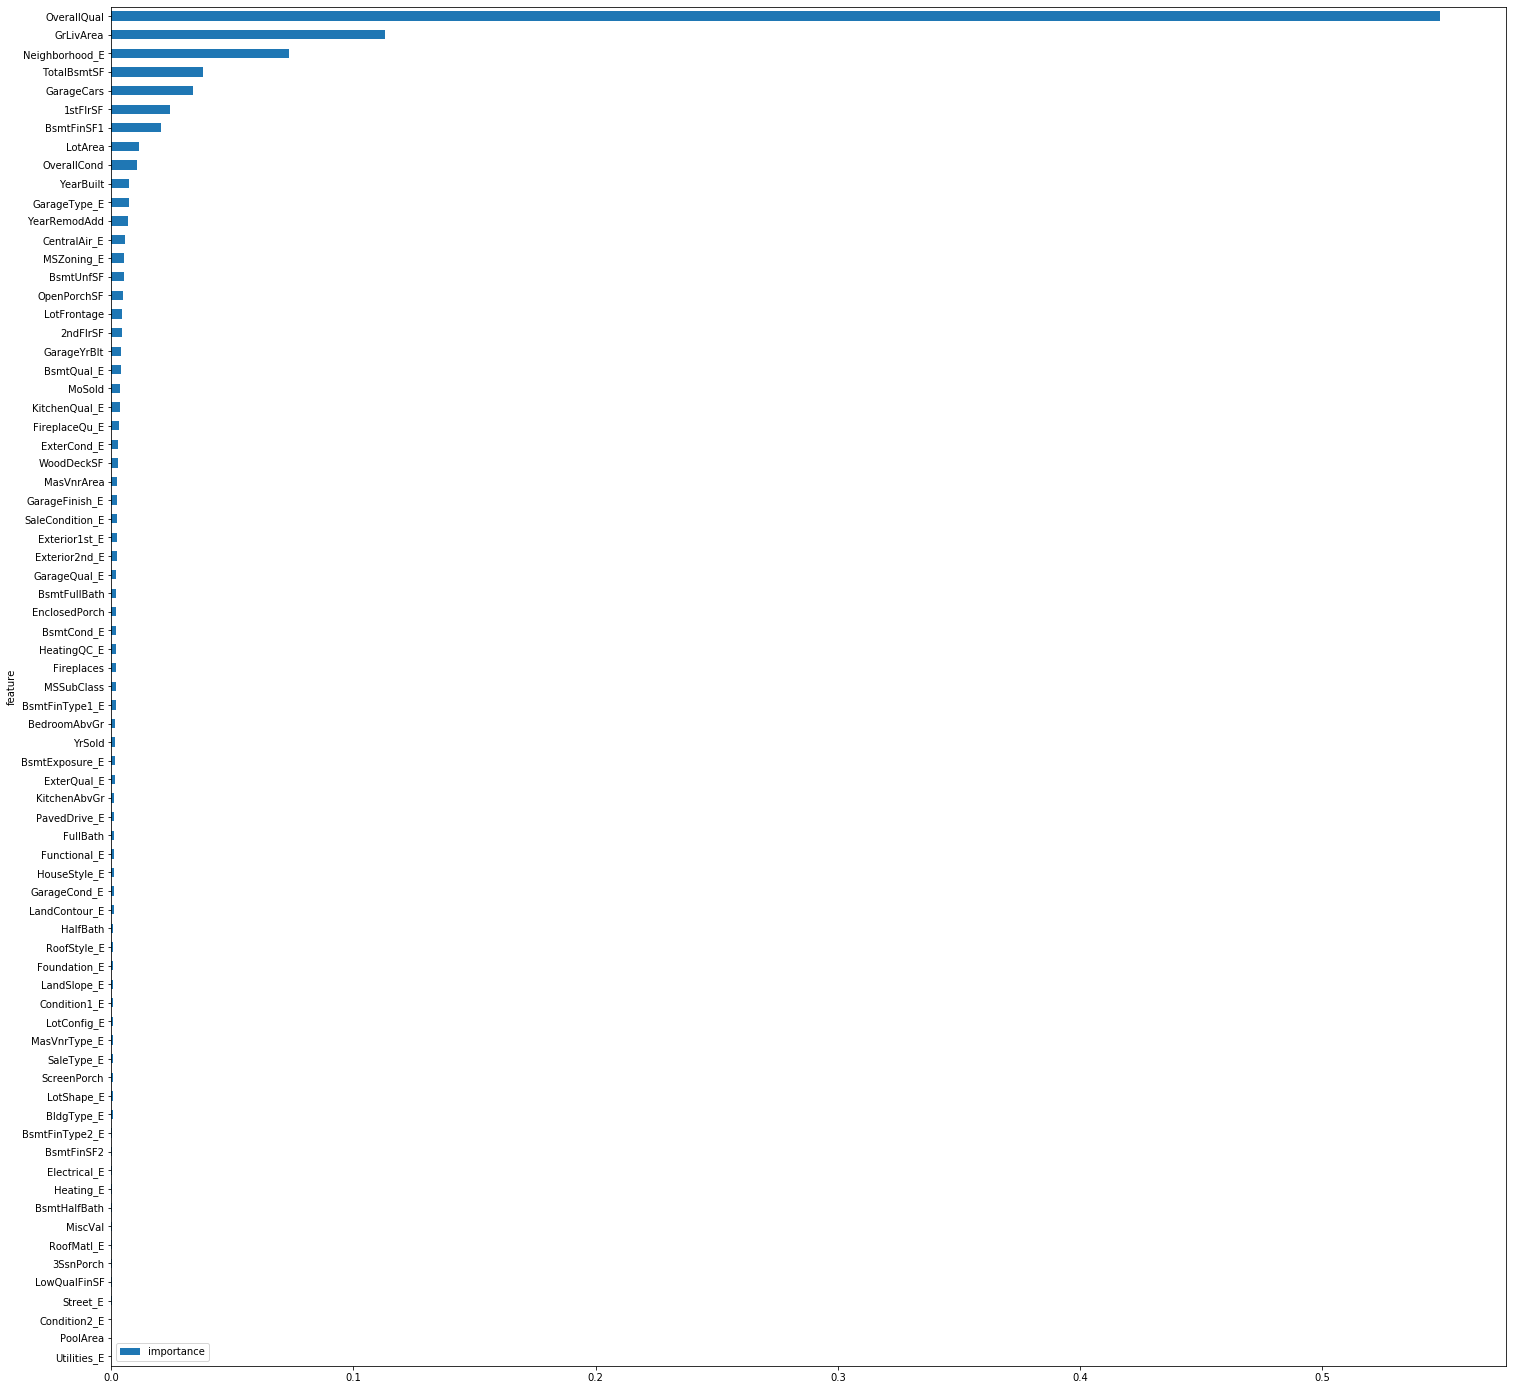

In [29]:
features = pd.DataFrame()
features["feature"] = traindf.columns
features["importance"] = clf.feature_importances_
features.set_index("feature" , inplace = True)
features.sort_values(by = ["importance"] , ascending = True , inplace = True)

features.plot(kind = "barh" , figsize = (25,25))

In [30]:
features.sort_values(by=["importance"] , ascending=False , inplace = True)
features

,importance
feature,
OverallQual,0.548634
GrLivArea,0.112973
Neighborhood_E,0.073409
TotalBsmtSF,0.037703
GarageCars,0.033539
1stFlrSF,0.024158
BsmtFinSF1,0.020384
LotArea,0.011511
OverallCond,0.010649


In [31]:
# only considering top 27 features! (20 for gb and rf)
val_features = features.iloc[:30]
val_features.index

Index(['OverallQual', 'GrLivArea', 'Neighborhood_E', 'TotalBsmtSF',
       'GarageCars', '1stFlrSF', 'BsmtFinSF1', 'LotArea', 'OverallCond',
       'YearBuilt', 'GarageType_E', 'YearRemodAdd', 'CentralAir_E',
       'MSZoning_E', 'BsmtUnfSF', 'OpenPorchSF', 'LotFrontage', '2ndFlrSF',
       'GarageYrBlt', 'BsmtQual_E', 'MoSold', 'KitchenQual_E', 'FireplaceQu_E',
       'ExterCond_E', 'WoodDeckSF', 'MasVnrArea', 'GarageFinish_E',
       'SaleCondition_E', 'Exterior1st_E', 'Exterior2nd_E'],
      dtype='object', name='feature')

In [32]:
for col in traindf.columns:
    if col not in val_features.index:
        traindf.drop(col , axis = 1 , inplace = True)
        testdf.drop(col , axis = 1 , inplace = True)

In [33]:
X_train ,X_test , Y_train , Y_test = train_test_split(traindf , target , test_size = 0.2)

In [39]:
best = {'colsample_bylevel': 0.6971640307744038, 'colsample_bytree': 0.6222251306452113, 
        'gamma': 0.045557016198868025, 'learning_rate': 0.012334455088591312, 'max_depth': 4.0, 
        'n_estimators': 2100.0, 'reg_lambda': 2.1713829044702413, 'subsample': 0.8459257473555255}

xgb = XGBRegressor(random_state=3,
                        n_estimators=int(best['n_estimators']), 
                        colsample_bytree= best['colsample_bytree'],
                        gamma= best['gamma'],
                        learning_rate= best['learning_rate'],
                        max_depth= int(best['max_depth']),
                        subsample= best['subsample'],
                        colsample_bylevel= best['colsample_bylevel'],
                        reg_lambda= best['reg_lambda'],
                        objective="reg:squarederror"
                       )

In [40]:
xgb.fit(X_train , Y_train)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             importance_type='gain', learning_rate=0.012334455088591312,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=3, reg_alpha=0,
             reg_lambda=2.1713829044702413, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8459257473555255, verbosity=1)

In [41]:
xgb.score(X_test , Y_test)

0.9324688359010463

In [42]:
best_m = xgb
best_m.fit(traindf , target)

XGBRegressor(base_score=0.5, booster='gbtree',
             colsample_bylevel=0.6971640307744038, colsample_bynode=1,
             colsample_bytree=0.6222251306452113, gamma=0.045557016198868025,
             importance_type='gain', learning_rate=0.012334455088591312,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=2100, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=3, reg_alpha=0,
             reg_lambda=2.1713829044702413, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8459257473555255, verbosity=1)

In [43]:
predictions = best_m.predict(testdf)
predictions = np.exp(predictions)
sub = pd.read_csv("./Datasets/adv-house-pred/test.csv")
Id = sub["Id"]
sub = pd.DataFrame({"Id" : Id , "SalePrice" : predictions})
sub.to_csv("submission2.csv" , index=False)